In [1]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# 加载CLIP的RN50模型
model, preprocess = clip.load("RN50", device="cpu")
model.eval()  # 设置模型为评估模式

# 加载并预处理图片
image_path = r"/root/autodl-tmp/datasets/image_caption_generation/COCO2017/val2017/000000038118.jpg"  # 替换为你的图像路径
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)  # [1, 3, 224, 224]

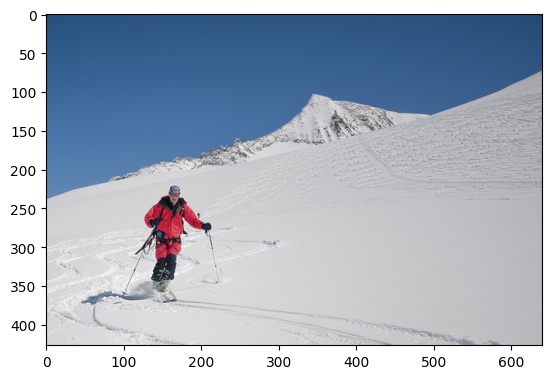

In [3]:
plt.imshow(plt.imread(image_path))

In [ ]:
print(model.visual.transformer.resblocks)

In [7]:
# 用于暂存中间层激活
activation_maps = {}


def get_activation(name):
    def hook(model, input, output):
        # 将该层输出存入字典
        activation_maps[name] = output.detach()

    return hook


# 注册所需层的hook
model.visual.layer1.register_forward_hook(get_activation("layer1"))
model.visual.layer2.register_forward_hook(get_activation("layer2"))
model.visual.layer3.register_forward_hook(get_activation("layer3"))
model.visual.layer4.register_forward_hook(get_activation("layer4"))

In [8]:
with torch.no_grad():
    _ = model.encode_image(input_tensor)

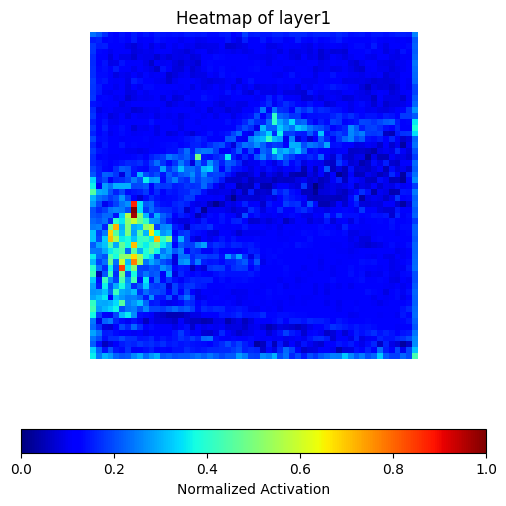

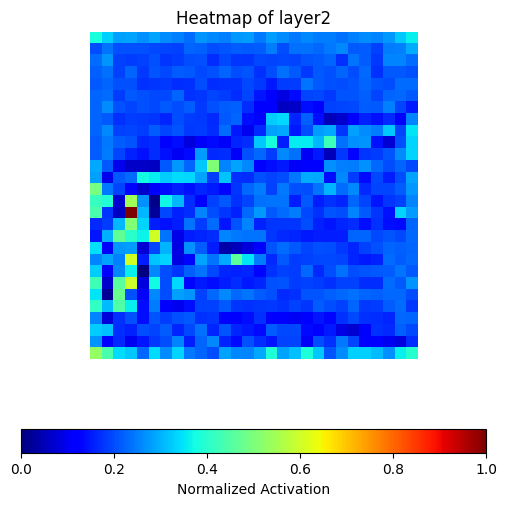

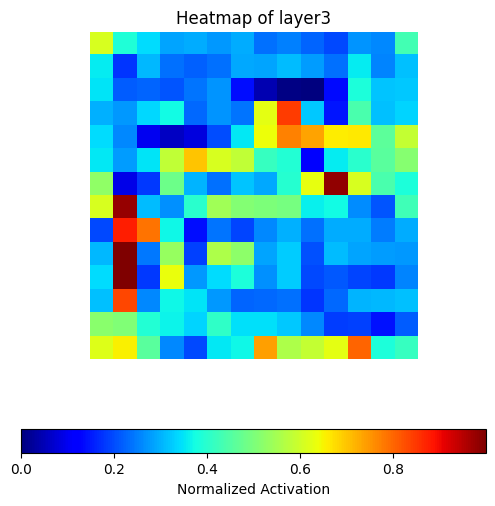

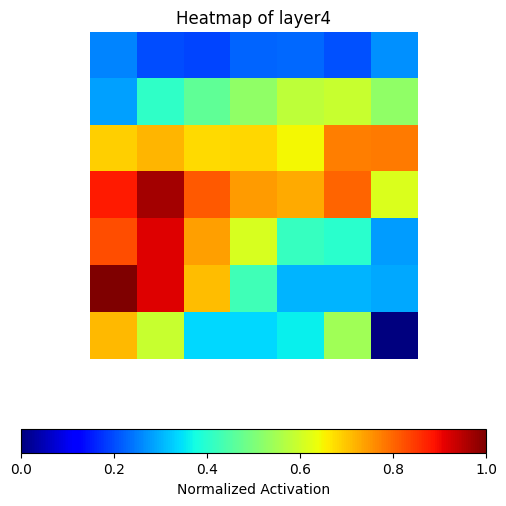

In [ ]:
for layer_name, activation in activation_maps.items():
    # activation: [1, C, H, W]
    act = activation[0]  # 去掉 batch_size 维度，变为 [C, H, W]

    # 对通道维度做平均：得到 [H, W]
    act_mean = act.mean(dim=0).cpu().numpy()

    # 归一化到 [0, 1] 之间
    act_min, act_max = act_mean.min(), act_mean.max()
    act_norm = (act_mean - act_min) / (act_max - act_min + 1e-8)

    # 显示热力图
    plt.figure(figsize=(6, 6))
    plt.imshow(act_norm, cmap="jet")
    # plt.colorbar()
    # 在下面放colorbar
    plt.gcf().subplots_adjust(bottom=0.1)
    cbar = plt.colorbar(plt.imshow(act_norm, cmap="jet"), orientation="horizontal")
    # cbar.set_label("Normalized Activation")
    # 增加label，这个label表示这个colorbar里面颜色变化的含义
    cbar.set_label("Normalized Activation")
    plt.title(f"Heatmap of {layer_name}")
    plt.axis("off")
    plt.show()

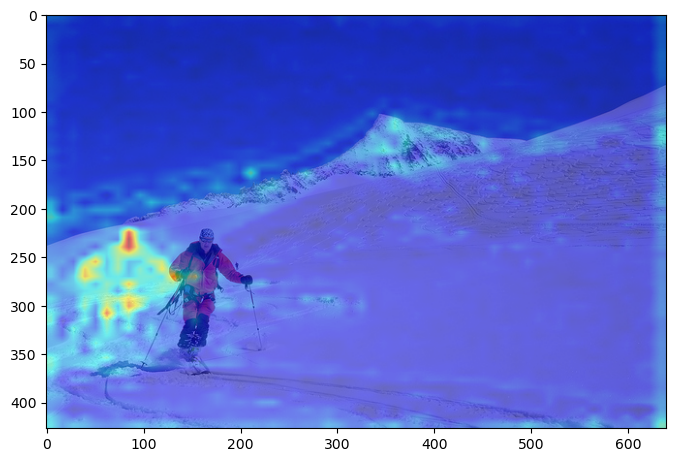

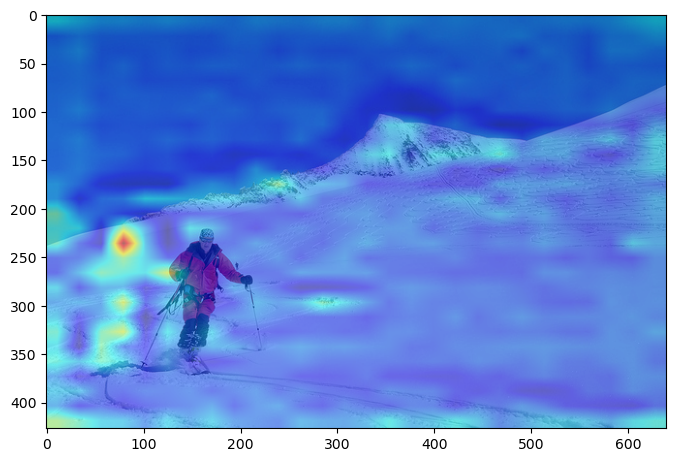

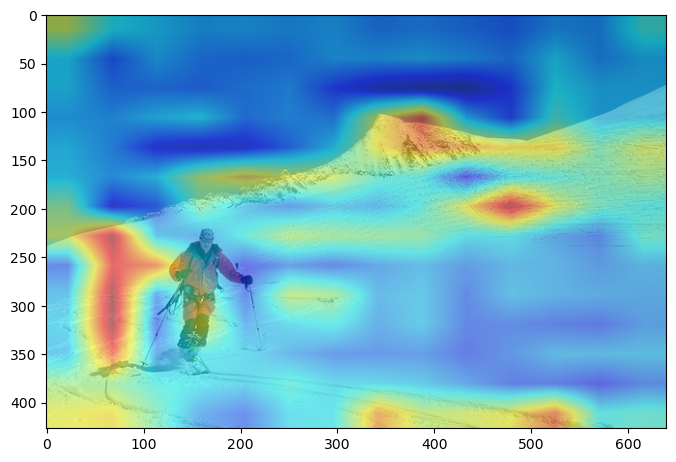

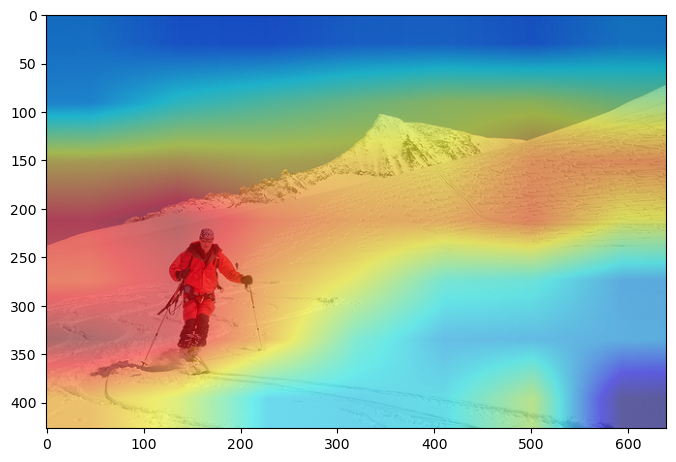

In [14]:
import cv2

for layer_name, activation in activation_maps.items():
    # 取 [H, W]
    act_mean = activation[0].mean(dim=0).cpu().numpy()

    # 归一化
    act_min, act_max = act_mean.min(), act_mean.max()
    act_norm = (act_mean - act_min) / (act_max - act_min + 1e-8)

    # 将[H, W]放大到与原图尺寸一致
    # 注意：输入到CLIP的图像是224x224，这里我们假设原图并没有被特别裁剪。
    # 如果想严格对齐，需要保持一致的resize过程。
    heatmap_resized = cv2.resize(act_norm, (image.width, image.height))

    # 将热力图转换为彩色
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # 将原图转换为数组
    image_array = np.array(image)[:, :, ::-1]  # PIL -> OpenCV BGR

    # 通过加权和叠加显示
    alpha = 0.5  # 透明度
    overlay = cv2.addWeighted(image_array, 1 - alpha, heatmap_color, alpha, 0)

    # 显示或保存
    plt.figure(figsize=(8, 6))
    plt.imshow(overlay[:, :, ::-1])  # BGR -> RGB
    # plt.title(f"{layer_name} Heatmap Overlay")
    # plt.axis("off")
    plt.show()